# Deep Learning Project - Traffic Signs Image Classification

In [1]:
import os, shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Functions

In [2]:
def save_hist_to_excel(filename):
    df = pd.DataFrame(history.history)
    df.to_excel(filename + '.xlsx')

## Overview of the training data

In [6]:
#setting the training directory (the training images can be found there, already sorted by class into folders)
# base_training_dir = "/Users/franz/Desktop/DL Project/Train/Final_Training/Images"
base_training_dir = "/Users/philippmetzger/Documents/GitHub/Deep_Learning_Project_Group_10/Data/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/"

#setting the directory where the selected training and validation images will be stored in
# created_dir = "/Users/franz/Desktop/DL Project/Selected"
created_dir = "/Users/philippmetzger/Documents/GitHub/Deep_Learning_Project_Group_10/Data/Selected"

#storing all the folder names that belong to the respective classes
all_classes = sorted(i for i in os.listdir(base_training_dir) if i.startswith("0"))

print("There are", len(all_classes), "different classes within the training data!")

There are 43 different classes within the training data!


In [4]:
#getting the number of images within each class of the training data
amount_per_class = {}

for i in range(len(all_classes)):
    directory = base_training_dir + "/" + all_classes[i]
    amount_per_class[i] = len(sorted(i for i in os.listdir(directory) if i.startswith("0")))

amount_per_class_df = pd.DataFrame.from_dict(amount_per_class, orient='index').rename(columns={0:"amount"})
amount_per_class_df.index.name = 'class'

#remove the "#" of the following line to display the number of images within each class
#amount_per_class_df

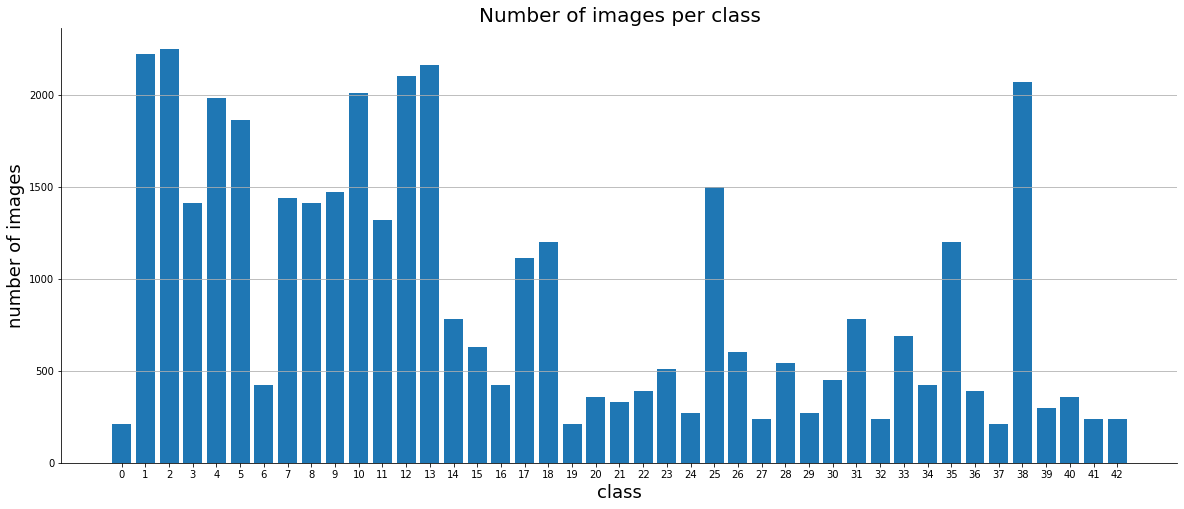

In [5]:
#displaying the number of images per class visually

plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots()
plt.bar(amount_per_class_df.index, amount_per_class_df.amount)
plt.title("Number of images per class", fontsize=20)
plt.xlabel('class', fontsize=18)
plt.ylabel('number of images', fontsize=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(amount_per_class_df.index)
plt.grid(axis="y")
plt.show()

As it can be seen in the bar chart, the dataset is highly unbalanced. Some classes have over 2000 instances, while others only have 210.

In [6]:
#displaying the 20 classes with the fewest images
amount_per_class_df.sort_values("amount").head(20).T

class,0,37,19,32,27,41,42,24,29,39,21,40,20,36,22,6,16,34,30,23
amount,210,210,210,240,240,240,240,270,270,300,330,360,360,390,390,420,420,420,450,510


Within each class, there are several groups of images, that belong together (these are basically all images of the very same traffic sign, that just differ in that they were made as a series while approaching the actual sign). These series of images shouldn't be splitted later when the data is split into training and validation sets, so some precautions might be useful:

In [7]:
#checking the size(=amount of images) of these series and whether they are all having the same size

#running a for loop over all classes
for i in range(len(all_classes)):
    directory = base_training_dir + "/" + all_classes[i]
    
    #get the names of all images within a class
    list_of_images = sorted(i for i in os.listdir(directory) if i.startswith("0"))

    image_series = []
    
    #store all the prefixes of the images (which correspond to the series they belong to)
    for element in list_of_images:
        image_series.append(element.split("_")[0])
    
    #count the frequency of each prefix, which equals the size of each respective series
    image_counts = pd.Series(image_series).value_counts().sort_index()

    for element in image_counts.values.tolist():
        if element != image_counts.values.tolist()[0]:
            #this line will show if there is a series that contains not the same number of images than the others
            print("There is a series whose number doesn't match the others in class", all_classes[i], ", with the prefix", image_counts.sort_values().index[0], "!\nIt only contains", element, "images.")
            

#apart from only one series, all others consist of exactly 30 images
print("All the other series of images contain exactly", image_counts.values.tolist()[0], "images!")

There is a series whose number doesn't match the others in class 00033 , with the prefix 00019 !
It only contains 29 images.
All the other series of images contain exactly 30 images!


## Split into training and validation datasets

As already mentioned, it is important for the split into training and validation sets that the individual image series stay together. As a first approach, there will be 210 images used per class, as this number corresponds to the amount of images in the "smallest" class. This will fix the problem of imbalance in the dataset. Subsequently, the data will be splitted by a 5:2 (150:60) ratio into training and validation set, in order to guarantee that the series will stay together.

In [8]:
#creating folders within the class folders for the training and validation sets
train_dir = os.path.join(created_dir, "training")
os.mkdir(train_dir)
validation_dir = os.path.join(created_dir, "validation")
os.mkdir(validation_dir)

#creating folders for each class within the training and validation folders
for i in range(len(all_classes)):
    directory_train = os.path.join(train_dir, all_classes[i])
    directory_val = os.path.join(validation_dir, all_classes[i])

    os.mkdir(directory_train)
    os.mkdir(directory_val)

In [9]:
#creating a list that contains the names of the 1st, 2nd and 3rd series of images (3x30 names)
training_names = []

for i in range(5):
    name = "0000" + str(i)
    for i2 in range(30):
        if i2 < 10:
            name = name + "_0000" + str(i2) + ".ppm"
            training_names.append(name)
            name = "0000" + str(i)
        else:
            name = name + "_000" + str(i2) + ".ppm"
            training_names.append(name)
            name = "0000" + str(i)


#creating a list that contains the names of the 4th and 5th series of images (2x30 names)
val_names = []

for i in range(5,7):
    name = "0000" + str(i)
    for i2 in range(30):
        if i2 < 10:
            name = name + "_0000" + str(i2) + ".ppm"
            val_names.append(name)
            name = "0000" + str(i)
        else:
            name = name + "_000" + str(i2) + ".ppm"
            val_names.append(name)
            name = "0000" + str(i)

In [10]:
#copying the first 3 series within a class into the train folder and the 2 consecutive series into the validation folder 
for i in range(len(all_classes)):

    for name in training_names:
        src = base_training_dir + "/" + all_classes[i] + "/" + name
        dst = train_dir + "/" + all_classes[i] + "/"  + name
        shutil.copyfile(src, dst)
    
    for name in val_names:
        src = base_training_dir + "/" + all_classes[i] + "/" + name
        dst = validation_dir + "/" + all_classes[i] + "/"  + name
        shutil.copyfile(src, dst)

Now, there should be exactly 150 images within the train folder of each class and 60 images within the validation folder. Having 43 different classes, this means that there are a total of 6,450 (150x43) training images and another 2,580 (60x43) validation images. A sanity check will show if this worked correctly:

In [11]:
for i in range(len(all_classes)):
    print("Class", i, ": training set size =", len(os.listdir(train_dir + "/" + all_classes[i])), "; validation set size:", len(os.listdir(validation_dir + "/" + all_classes[i])))

Class 0 : training set size = 150 ; validation set size: 60
Class 1 : training set size = 150 ; validation set size: 60
Class 2 : training set size = 150 ; validation set size: 60
Class 3 : training set size = 150 ; validation set size: 60
Class 4 : training set size = 150 ; validation set size: 60
Class 5 : training set size = 150 ; validation set size: 60
Class 6 : training set size = 150 ; validation set size: 60
Class 7 : training set size = 150 ; validation set size: 60
Class 8 : training set size = 150 ; validation set size: 60
Class 9 : training set size = 150 ; validation set size: 60
Class 10 : training set size = 150 ; validation set size: 60
Class 11 : training set size = 150 ; validation set size: 60
Class 12 : training set size = 150 ; validation set size: 60
Class 13 : training set size = 150 ; validation set size: 60
Class 14 : training set size = 150 ; validation set size: 60
Class 15 : training set size = 150 ; validation set size: 60
Class 16 : training set size = 150

As it can be seen, it worked correctly!

## Data Preprocessing

After running the upper part once, the notebook can be started from here from now on:

In [3]:
#this cell is optional and the notebook should be runned from here once the upper part has been executed once

import os, shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# train_dir = "/Users/franz/Desktop/DL Project/Selected/training"
# validation_dir = "/Users/franz/Desktop/DL Project/Selected/validation"

train_dir = "/Users/philippmetzger/Documents/GitHub/Deep_Learning_Project_Group_10/Data/Selected/training"
validation_dir = "/Users/philippmetzger/Documents/GitHub/Deep_Learning_Project_Group_10/Data/Selected/validation"

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode="categorical")

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode="categorical")

Found 6450 images belonging to 43 classes.
Found 2580 images belonging to 43 classes.


## Draft of the model

#### Building the model

In [6]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2) ))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense (43, activation='softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               42467840  
_________________________________________________________________
dense_1 (Dense)              (None, 43)                2

#### Training the model

In [8]:
from keras import optimizers

#compilation
model.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["acc"])

In [9]:
import sys
from PIL import Image
sys.modules['Image'] = Image

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 43)


In [10]:
history = model.fit_generator(
    train_generator,
    epochs=20,
    validation_data=validation_generator)

/Users/philippmetzger/anaconda3/envs/dl_pip_2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
323/323 [==============================] - 186s 576ms/step - loss: 2.9580 - acc: 0.2718 - val_loss: 2.3574 - val_acc: 0.4097
Epoch 2/20
323/323 [==============================] - 182s 562ms/step - loss: 0.7916 - acc: 0.8174 - val_loss: 1.8216 - val_acc: 0.5581
Epoch 3/20
323/323 [==============================] - 184s 571ms/step - loss: 0.3116 - acc: 0.9329 - val_loss: 1.9097 - val_acc: 0.5500
Epoch 4/20
323/323 [==============================] - 182s 562ms/step - loss: 0.1447 - acc: 0.9662 - val_loss: 1.8983 - val_acc: 0.6004
Epoch 5/20
323/323 [==============================] - 187s 578ms/step - loss: 0.0699 - acc: 0.9864 - val_loss: 2.0244 - val_acc: 0.6264
Epoch 6/20
323/323 [==============================] - 192s 595ms/step - loss: 0.0473 - acc: 0.9921 - val_loss: 2.0287 - val_acc: 0.6326
Epoch 7/20
323/323 [==============================] - 189s 584ms/step - loss: 0.0271 - acc: 0.9959 - val_loss: 1.9425 - val_acc: 0.6357
Epoch 8/20
323/323 [============================

In [11]:
save_hist_to_excel('history_base_2')

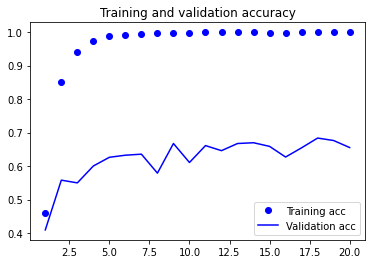

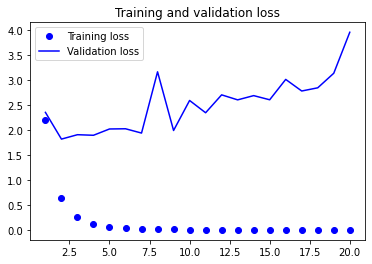

In [12]:
#Displaying curves of loss and accuracy during training

import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.show()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

As it can be seen, the major problem so far is overfitting!

## Overfitting reduce technique 1: Rebuidling the model with dropout

Overview of some techniques: https://towardsdatascience.com/deep-learning-3-more-on-cnns-handling-overfitting-2bd5d99abe5d

In [7]:
train_dir = os.path.join(created_dir, "training")
# os.mkdir(train_dir)
validation_dir = os.path.join(created_dir, "validation")
# os.mkdir(validation_dir)

In [8]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2) ))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense (43, activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dropout (Dropout)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               4

In [10]:
from keras import optimizers

#compilation
model.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["acc"])

In [11]:
history = model.fit_generator(
    train_generator,
    epochs=20,
    validation_data=validation_generator
    )

/Users/philippmetzger/anaconda3/envs/dl_pip_2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
323/323 [==============================] - 189s 584ms/step - loss: 3.0131 - acc: 0.2447 - val_loss: 2.4471 - val_acc: 0.3779
Epoch 2/20
323/323 [==============================] - 188s 583ms/step - loss: 0.8654 - acc: 0.7853 - val_loss: 2.2819 - val_acc: 0.4915
Epoch 3/20
323/323 [==============================] - 187s 579ms/step - loss: 0.3307 - acc: 0.9259 - val_loss: 2.3874 - val_acc: 0.4946
Epoch 4/20
323/323 [==============================] - 180s 556ms/step - loss: 0.1591 - acc: 0.9659 - val_loss: 2.4413 - val_acc: 0.5516
Epoch 5/20
323/323 [==============================] - 180s 558ms/step - loss: 0.0815 - acc: 0.9834 - val_loss: 2.6280 - val_acc: 0.5659
Epoch 6/20
323/323 [==============================] - 180s 556ms/step - loss: 0.0473 - acc: 0.9892 - val_loss: 2.8061 - val_acc: 0.5771
Epoch 7/20
323/323 [==============================] - 181s 562ms/step - loss: 0.0338 - acc: 0.9930 - val_loss: 2.7786 - val_acc: 0.5907
Epoch 8/20
323/323 [============================

In [12]:
save_hist_to_excel('history_dropout_2_check')

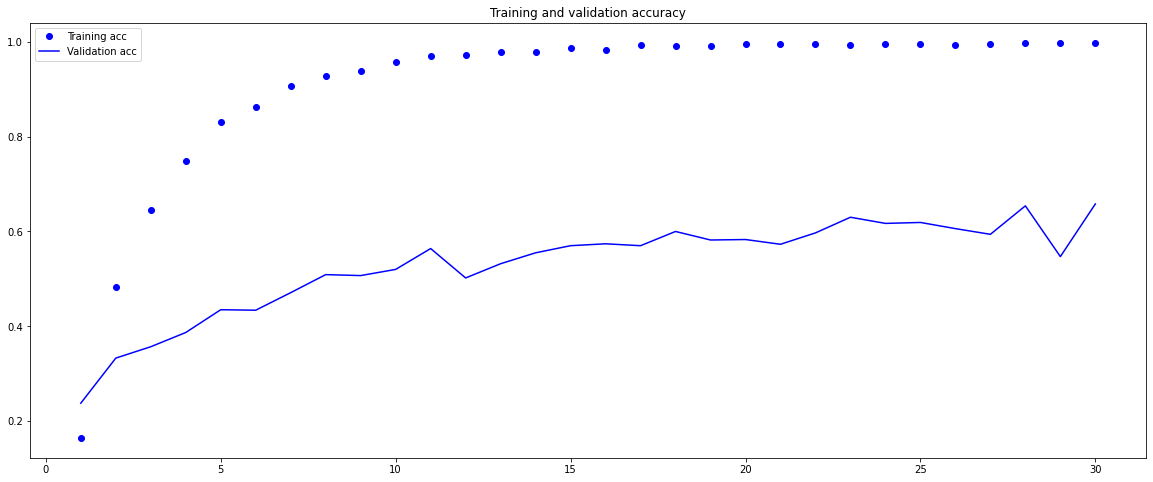

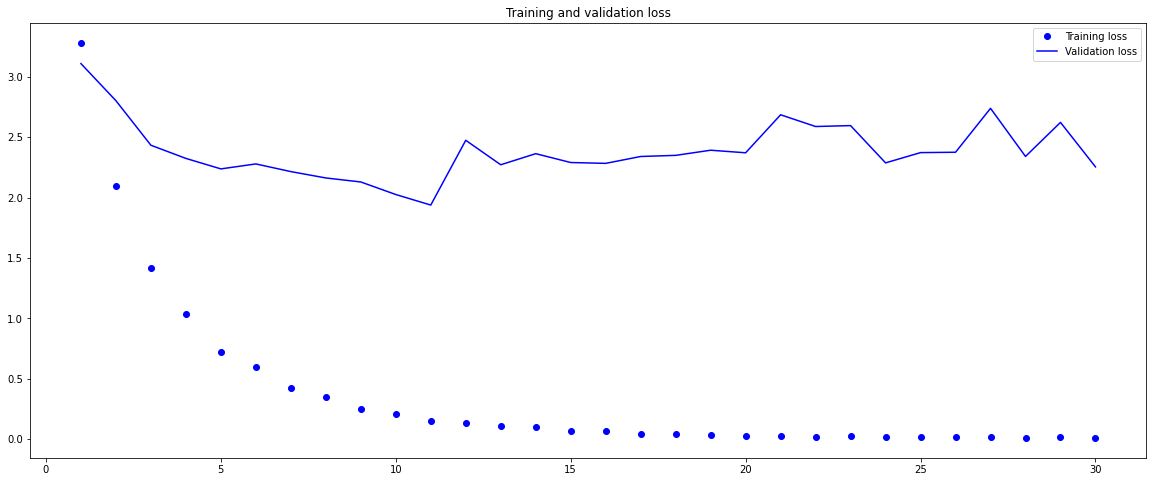

In [29]:
#Displaying curves of loss and accuracy during training

import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.show()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

## Overfitting reduce technique 2: Data Augmentation

In [5]:
from keras.preprocessing.image import ImageDataGenerator

#defining the parameters how the images will be adjusted
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

##### Creating augmented images

In [33]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import random

completed = 1
#getting one image from each series of pictures and create 30 new augmented ones and save them
for element in range(len(os.listdir(train_dir))):
    if ".DS_Store" not in os.listdir(train_dir)[element]:
        series = []

        while len(series) < 5:

            names = [os.path.join(train_dir + "/" + os.listdir(train_dir)[element], name) for name in os.listdir(train_dir + "/" + os.listdir(train_dir)[element])]
            for element_name in names:
                if ".DS_Store" in element_name:
                    names.remove(element_name)
                
            #choosing a random image
            number = random.randint(0, 149)
        
        
            img_path = names[number]
    
            if img_path.split("/")[-1].split("_")[0] not in series:
                #make sure that each series will be dealt with
                series.append(img_path.split("/")[-1].split("_")[0])

                img = image.load_img(img_path, target_size=(150, 150))

                x = image.img_to_array(img)

                x = x.reshape((1,) + x.shape)

                i = 0
                #create the images and save them
                for batch in datagen.flow(x, batch_size=1):
                    fig = plt.figure(i,frameon=False,figsize=(6,6))
                    ax = plt.Axes(fig, [0., 0., 1., 1.])
                    ax.set_axis_off()
                    fig.add_axes(ax)
                    imgplot = ax.imshow(image.array_to_img(batch[0]))
                    image_name = str(i)
                    plt.savefig(train_dir + "/" + os.listdir(train_dir)[element] + "/" + img_path.split("/")[-1].split("_")[0] +"_augmented"+str(i)+".jpg")
                    plt.close()
                    i += 1
                    if i == 30:
                        break
                    
    print(str(completed)+"/43 completed...")
    completed += 1

1/43 completed...
2/43 completed...
3/43 completed...
4/43 completed...
5/43 completed...
6/43 completed...
7/43 completed...
8/43 completed...
9/43 completed...
10/43 completed...
11/43 completed...
12/43 completed...
13/43 completed...
14/43 completed...
15/43 completed...
16/43 completed...
17/43 completed...
18/43 completed...
19/43 completed...
20/43 completed...
21/43 completed...
22/43 completed...
23/43 completed...
24/43 completed...
25/43 completed...
26/43 completed...
27/43 completed...
28/43 completed...
29/43 completed...
30/43 completed...
31/43 completed...
32/43 completed...
33/43 completed...
34/43 completed...
35/43 completed...
36/43 completed...
37/43 completed...
38/43 completed...
39/43 completed...
40/43 completed...
41/43 completed...
42/43 completed...
43/43 completed...
44/43 completed...


##### Redefining the generators

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode="categorical")

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode="categorical")

Found 12900 images belonging to 43 classes.
Found 2580 images belonging to 43 classes.


##### Rebuilding the model

In [6]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2) ))
model.add(layers.Flatten())

# Added by Philipp to test dropout(0.5) and augmented in combination
model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense (43, activation='softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               42467840  
_________________________________________________________________
dense_1 (Dense)              (None, 43)                2

##### Training the model

In [8]:
from keras import optimizers

#compilation
model.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["acc"])

In [9]:
import sys
from PIL import Image
sys.modules['Image'] = Image

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 43)


In [11]:
history = model.fit_generator(
    train_generator,
    epochs=20,
    validation_data=validation_generator)

Epoch 1/20
645/645 [==============================] - 354s 548ms/step - loss: 1.3520 - acc: 0.6289 - val_loss: 2.1274 - val_acc: 0.4442
Epoch 2/20
645/645 [==============================] - 355s 551ms/step - loss: 0.6726 - acc: 0.8240 - val_loss: 2.2587 - val_acc: 0.4740
Epoch 3/20
645/645 [==============================] - 355s 551ms/step - loss: 0.3640 - acc: 0.9062 - val_loss: 2.3538 - val_acc: 0.4822
Epoch 4/20
645/645 [==============================] - 375s 581ms/step - loss: 0.2018 - acc: 0.9485 - val_loss: 2.4742 - val_acc: 0.5326
Epoch 5/20
645/645 [==============================] - 398s 618ms/step - loss: 0.1122 - acc: 0.9716 - val_loss: 2.6648 - val_acc: 0.5457
Epoch 6/20
645/645 [==============================] - 368s 570ms/step - loss: 0.0690 - acc: 0.9832 - val_loss: 2.7347 - val_acc: 0.5384
Epoch 7/20
645/645 [==============================] - 397s 616ms/step - loss: 0.0408 - acc: 0.9913 - val_loss: 2.9653 - val_acc: 0.5457
Epoch 8/20
645/645 [============================

In [12]:
save_hist_to_excel('history_augmented_2')

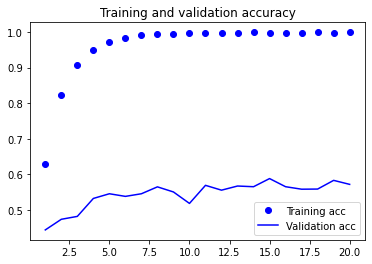

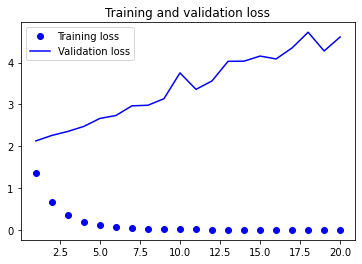

In [13]:
#Displaying curves of loss and accuracy during training

import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.show()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

## Dropout like above but with diffrent values

### 0.2

In [13]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2) ))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense (43, activation='softmax'))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 82944)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

In [15]:
from keras import optimizers

#compilation
model.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["acc"])

In [16]:
history = model.fit_generator(
    train_generator,
    epochs=15,
    validation_data=validation_generator
    )

Epoch 1/15
323/323 [==============================] - 178s 550ms/step - loss: 3.0649 - acc: 0.2448 - val_loss: 2.5909 - val_acc: 0.3298
Epoch 2/15
323/323 [==============================] - 178s 552ms/step - loss: 0.8913 - acc: 0.7890 - val_loss: 2.2547 - val_acc: 0.4492
Epoch 3/15
323/323 [==============================] - 179s 555ms/step - loss: 0.3748 - acc: 0.9123 - val_loss: 2.3774 - val_acc: 0.5085
Epoch 4/15
323/323 [==============================] - 177s 549ms/step - loss: 0.1870 - acc: 0.9591 - val_loss: 2.2665 - val_acc: 0.5407
Epoch 5/15
323/323 [==============================] - 179s 553ms/step - loss: 0.0923 - acc: 0.9834 - val_loss: 2.3543 - val_acc: 0.5550
Epoch 6/15
323/323 [==============================] - 177s 549ms/step - loss: 0.0549 - acc: 0.9892 - val_loss: 2.4443 - val_acc: 0.5519
Epoch 7/15
323/323 [==============================] - 178s 552ms/step - loss: 0.0375 - acc: 0.9919 - val_loss: 2.3617 - val_acc: 0.5833
Epoch 8/15
323/323 [============================

In [17]:
save_hist_to_excel('history_dropout_0_2')

### 0.3

In [18]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2) ))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense (43, activation='softmax'))

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 82944)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)              

In [20]:
from keras import optimizers

#compilation
model.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["acc"])

In [21]:
history = model.fit_generator(
    train_generator,
    epochs=15,
    validation_data=validation_generator
    )

Epoch 1/15
323/323 [==============================] - 195s 603ms/step - loss: 3.0359 - acc: 0.2434 - val_loss: 2.4106 - val_acc: 0.3822
Epoch 2/15
323/323 [==============================] - 185s 573ms/step - loss: 0.8761 - acc: 0.7934 - val_loss: 2.2675 - val_acc: 0.4957
Epoch 3/15
323/323 [==============================] - 183s 567ms/step - loss: 0.3536 - acc: 0.9226 - val_loss: 2.1824 - val_acc: 0.5484
Epoch 4/15
323/323 [==============================] - 188s 582ms/step - loss: 0.1593 - acc: 0.9660 - val_loss: 2.3469 - val_acc: 0.5643
Epoch 5/15
323/323 [==============================] - 193s 597ms/step - loss: 0.0868 - acc: 0.9811 - val_loss: 2.3289 - val_acc: 0.5981
Epoch 6/15
323/323 [==============================] - 183s 567ms/step - loss: 0.0419 - acc: 0.9939 - val_loss: 2.5772 - val_acc: 0.5915
Epoch 7/15
323/323 [==============================] - 185s 572ms/step - loss: 0.0192 - acc: 0.9960 - val_loss: 2.4892 - val_acc: 0.5988
Epoch 8/15
323/323 [============================

In [22]:
save_hist_to_excel('history_dropout_0_3')

### 0.4

In [23]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2) ))
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense (43, activation='softmax'))

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 82944)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)              

In [25]:
from keras import optimizers

#compilation
model.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["acc"])

In [26]:
history = model.fit_generator(
    train_generator,
    epochs=15,
    validation_data=validation_generator
    )

Epoch 1/15
323/323 [==============================] - 200s 619ms/step - loss: 2.9334 - acc: 0.2649 - val_loss: 2.7656 - val_acc: 0.3574
Epoch 2/15
323/323 [==============================] - 202s 624ms/step - loss: 0.8751 - acc: 0.7777 - val_loss: 2.4675 - val_acc: 0.4609
Epoch 3/15
323/323 [==============================] - 195s 602ms/step - loss: 0.3669 - acc: 0.9104 - val_loss: 2.6213 - val_acc: 0.4907
Epoch 4/15
323/323 [==============================] - 194s 600ms/step - loss: 0.2060 - acc: 0.9543 - val_loss: 2.7714 - val_acc: 0.5155
Epoch 5/15
323/323 [==============================] - 193s 599ms/step - loss: 0.1015 - acc: 0.9757 - val_loss: 2.8716 - val_acc: 0.5376
Epoch 6/15
323/323 [==============================] - 207s 642ms/step - loss: 0.0614 - acc: 0.9867 - val_loss: 3.0164 - val_acc: 0.5267
Epoch 7/15
323/323 [==============================] - 208s 643ms/step - loss: 0.0357 - acc: 0.9913 - val_loss: 3.1502 - val_acc: 0.5345
Epoch 8/15
323/323 [============================

In [27]:
save_hist_to_excel('history_dropout_0_4')

### 0.7

In [28]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2) ))
model.add(layers.Flatten())
model.add(layers.Dropout(0.7))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense (43, activation='softmax'))

In [29]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 82944)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)              

In [30]:
from keras import optimizers

#compilation
model.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["acc"])

In [ ]:
history = model.fit_generator(
    train_generator,
    epochs=15,
    validation_data=validation_generator
    )

Epoch 1/15
323/323 [==============================] - 211s 651ms/step - loss: 2.9202 - acc: 0.2561 - val_loss: 2.4372 - val_acc: 0.3570
Epoch 2/15
323/323 [==============================] - 226s 700ms/step - loss: 0.7988 - acc: 0.7948 - val_loss: 2.4268 - val_acc: 0.4853
Epoch 3/15
323/323 [==============================] - 189s 584ms/step - loss: 0.3376 - acc: 0.9218 - val_loss: 2.4121 - val_acc: 0.5236
Epoch 4/15
323/323 [==============================] - 197s 609ms/step - loss: 0.1680 - acc: 0.9619 - val_loss: 2.4201 - val_acc: 0.5391
Epoch 5/15
323/323 [==============================] - 197s 610ms/step - loss: 0.1015 - acc: 0.9743 - val_loss: 2.4481 - val_acc: 0.5527
Epoch 6/15
107/323 [========>.....................] - ETA: 2:08 - loss: 0.0476 - acc: 0.9900

In [ ]:
save_hist_to_excel('history_dropout_0_7')

### 0.9

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2) ))
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense (43, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
from keras import optimizers

#compilation
model.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["acc"])

In [ ]:
history = model.fit_generator(
    train_generator,
    epochs=15,
    validation_data=validation_generator
    )

In [ ]:
save_hist_to_excel('history_dropout_0_7')